Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# People Analytics using Neptune ML - Predicting Attrition and Career Progression

Hiring and retaining good personnel is a key characteristic to making an organization sucessful.  One way that organizations approach this problem is through the use of people analytics.  People analytics allow business leaders to make data-driven decisions about personnel-related issues such as recruiting, evaluation, hiring, promotion, and retention, etc.

Human resource and personnel data often contains a vast amount of information that shows the connections and relationships between individuals, companies, jobs, etc. such as:

* Who works for whom
* How has this person's career progressed
* What opportunities has this person had

This type of information can be efficently and effectively represented in the form of a graph.  Storing and thinking about this data as a series of connections enable us to gain some unique insights.  

In this notebook we will answer two specific questions that come up frequently when looking at HR data in terms of hiring and retaining personnel:

* Who is most likely to leave?
* What job should someone look at next?

To demonstrate how you might accomplish this we are going to use a well-known dataset originally from IBM that contains HR attrition data.  This dataset is available from [Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) under the [Open Data Commons License]( https://opendatacommons.org/licenses/dbcl/1-0/).

To answer these questions, we will be using [Neptune ML](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html) which is a feature of Amazon Neptune that enables users to automate the creation, management, and usage of Graph Neural Network (GNN) machine learning models within Amazon Neptune.  Neptune ML is built using [Amazon SageMaker](https://aws.amazon.com/sagemaker/) and [Deep Graph Library](https://www.dgl.ai/) and provides a simple and easy-to-use mechanism to build/train/maintain these models and then use the predictive capabilities of these models within a Gremlin query to predict elements or property values in the graph.

## Setup

Before we begin, we need to setup a few things. Most importantly, you will need to provide the path to an Amazon S3 bucket that we can use to store our data in.

In [ ]:
!cp ../../neptune_ml_utils.py .

In [ ]:
import neptune_ml_utils as neptune_ml
neptune_ml.check_ml_enabled()

s3_bucket_uri="s3://<INSERT S3 BUCKET OR PATH>"
# remove trailing slashes
s3_bucket_uri = s3_bucket_uri[:-1] if s3_bucket_uri.endswith('/') else s3_bucket_uri

## Import and explore data

Let's start by loading up the data using the associated CSV file and see what our data looks like. *Note* - This notebook assumes the cluster was empty before this command being run.

In [ ]:
import pandas as pd
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
pd.set_option('display.max_columns', None)
print(f'Our data file contains {df.shape[0]} columns and {df.shape[1]} rows.')
print('Here is what a few of them look like:')
df.head()

As you can see, the data contains 1470 rows and 35 columns.  Let's see how much overlap is in our data:

In [ ]:
print(f'Number of unique employees: {df["EmployeeNumber"].nunique()}')
print(f'Number of unique departments: {df["Department"].nunique()}')
print(f'Number of unique fields: {df["EducationField"].nunique()}')

Now that we have a high-level view of the data in our file, let's import it into Neptune.

## Import into Neptune

To accomplish our data import into Neptune we are going to use the [Neptune Bulk Loader](https://docs.aws.amazon.com/neptune/latest/userguide/bulk-load.html) with a CSV file format.  

Vertices loaded from a CSV are required to be in this format:
    
    ~id, name:String, age:Int, lang:String, ~label
    v1, "brad", 29, , person
    
Edges loaded from a CSV are required to be in this format:

    ~id, ~from, ~to, ~label, weight:Double
    e1, v1, v2, created, 0.4
    
Let's convert the employee data from our file into a compatible set of vertices and edges.         

* vertices
    * Employee
        * Age (int)
        * Attrition (categorical)
        * BusinessTravel (categorical)
        * DailyRate (int)
        * DistanceFromHome (int, but likely represents a category)
        * Education (int, but likely represents a category)
        * EmployeeCount (int)
        * EmployeeNumber (int)
        * EnvironmentSatisfaction (int, but likely represents a category)
        * Gender (category)
        * HourlyRate (int)
        * JobInvolvement (int, but likely represents a category)
        * JobLevel (int, but likely represents a category)
        * JobSatisfaction  (int, but likely represents a category)
        * MaritalStatus (category)
        * MonthlyIncome (int)
        * MonthlyRate (int)
        * NumCompaniesWorked (int)
        * Over18 (category)
        * OverTime (category)
        * PercentSalaryHike (int)
        * PerformanceRating  (int, but likely represents a category)
        * RelationshipSatisfaction (int, but likely represents a category)
        * StandardHours (int)
        * StockOptionLevel (int, but likely represents a category)
        * TotalWorkingYears (int)
        * TrainingTimesLastYear (int)
        * WorkLifeBalance (int, but likely represents a category)
        * YearsAtCompany (int)
        * YearsInCurrentRole (int)
        * YearsSinceLastPromotion (int)
        * YearsWithCurrManager (int)
    * Department
        * Department (string)
    * EducationField
        * EducationField (string)
    * JobRole
        * JobRole (string)
* edges
    * Employee-works_in->Department
    * Employee-has_education_level->EducationField
    * Employee-works_as->JobRole
    * JobRole-requires->EducationField
    * JobRole-part_of->Department
    
In our graph, our data model will look like this:

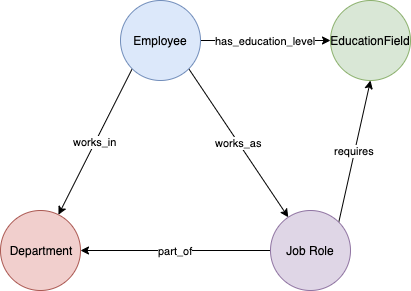
        
Using this model, we will try to predict the following:

* Attrition (node classification)
* Possible job roles (link prediction)

Before we can do that, we first need to create the CSV files and then upload them to S3, which is accomplished by running the two cells below.

In [ ]:
import numpy as np
import boto3
import os
import uuid
from urllib.parse import urlparse

# Create the output folder
output_folder = 'data-upload'
if os.path.exists(output_folder) == False:
    os.mkdir(output_folder)

# Create the Employee dataframe
empVdf = pd.DataFrame(columns=['~id', 
                               'Age:Int',
                                'Attrition:String',
                                'BusinessTravel:String',
                                'DailyRate:Int',
                                'DistanceFromHome:String',
                                'Education:String',
                                'EmployeeCount:Int',
                                'EmployeeNumber:Int',
                                'EnvironmentSatisfaction:String',
                                'Gender:String',
                                'HourlyRate:Int',
                                'JobInvolvement:String',
                                'JobLevel:String',
                                'JobSatisfaction:String',
                                'MaritalStatus:String',
                                'MonthlyIncome:Int',
                                'MonthlyRate:Int',
                                'NumCompaniesWorked:Int',
                                'Over18:String',
                                'OverTime:String',
                                'PercentSalaryHike:Int',
                                'PerformanceRating:String',
                                'RelationshipSatisfaction:String',
                                'StandardHours:Int',
                                'StockOptionLevel:String',
                                'TotalWorkingYears:Int',
                                'TrainingTimesLastYear:Int',
                                'WorkLifeBalance:String',
                                'YearsAtCompany:Int',
                                'YearsInCurrentRole:Int',
                                'YearsSinceLastPromotion:Int',
                                'YearsWithCurrManager:Int',
                               '~label'])
empVdf['Age:Int'] = df['Age']
empVdf['Attrition:String'] = df['Attrition']
empVdf['BusinessTravel:String'] = df['BusinessTravel']
empVdf['DailyRate:Int'] = df['DailyRate']
empVdf['DistanceFromHome:String'] = df['DistanceFromHome']
empVdf['Education:String'] = df['Education']
empVdf['EmployeeCount:Int'] = df['EmployeeCount']
empVdf['EmployeeNumber:Int'] = df['EmployeeNumber']
empVdf['EnvironmentSatisfaction:String'] = df['EnvironmentSatisfaction']
empVdf['Gender:String'] = df['Gender']
empVdf['HourlyRate:Int'] = df['HourlyRate']
empVdf['JobInvolvement:String'] = df['JobInvolvement']
empVdf['JobLevel:String'] = df['JobLevel']
empVdf['JobSatisfaction:String'] = df['JobSatisfaction']
empVdf['MaritalStatus:String'] = df['MaritalStatus']
empVdf['MonthlyIncome:Int'] = df['MonthlyIncome']
empVdf['MonthlyRate:Int'] = df['MonthlyRate']
empVdf['NumCompaniesWorked:Int'] = df['NumCompaniesWorked']
empVdf['Over18:String'] = df['Over18']
empVdf['OverTime:String'] = df['OverTime']
empVdf['PercentSalaryHike:Int'] = df['PercentSalaryHike']
empVdf['PerformanceRating:String'] = df['PerformanceRating']
empVdf['RelationshipSatisfaction:String'] = df['RelationshipSatisfaction']
empVdf['StandardHours:Int'] = df['StandardHours']
empVdf['StockOptionLevel:String'] = df['StockOptionLevel']
empVdf['TotalWorkingYears:Int'] = df['TotalWorkingYears']
empVdf['TrainingTimesLastYear:Int'] = df['TrainingTimesLastYear']
empVdf['WorkLifeBalance:String'] = df['WorkLifeBalance']
empVdf['YearsAtCompany:Int'] = df['YearsAtCompany']
empVdf['YearsInCurrentRole:Int'] = df['YearsInCurrentRole']
empVdf['YearsSinceLastPromotion:Int'] = df['YearsSinceLastPromotion']
empVdf['YearsWithCurrManager:Int'] = df['YearsWithCurrManager']

empVdf['~label'] = 'Employee'
empVdf['~id'] = np.arange(len(empVdf))
empVdf['~id'] = empVdf['~id'].apply(lambda x: f"emp{x}")
empVdf.to_csv(os.path.join(output_folder, 'vertex_emp.csv'), index=False)
emp_map = pd.Series(empVdf['~id'].values,index=empVdf['EmployeeNumber:Int']).to_dict()

# Create the Department dataframe
deptVdf = pd.DataFrame(columns=['~id', 
                               'Name:String',                                
                               '~label'])
deptVdf['Name:String'] = df['Department']

deptVdf['~label'] = 'Department'
deptVdf = deptVdf.drop_duplicates(subset=['Name:String'])
deptVdf['~id'] = np.arange(len(deptVdf))
deptVdf['~id'] = deptVdf['~id'].apply(lambda x: f"dept{x}")
deptVdf.to_csv(os.path.join(output_folder, 'vertex_dept.csv'), index=False)
dept_map = pd.Series(deptVdf['~id'].values,index=deptVdf['Name:String']).to_dict()

# Create the JobRole dataframe
roleVdf = pd.DataFrame(columns=['~id', 
                               'Name:String',                                
                               '~label'])
roleVdf['Name:String'] = df['JobRole']

roleVdf['~label'] = 'JobRole'
roleVdf = roleVdf.drop_duplicates(subset=['Name:String'])
roleVdf['~id'] = np.arange(len(roleVdf))
roleVdf['~id'] = roleVdf['~id'].apply(lambda x: f"role{x}")
roleVdf.to_csv(os.path.join(output_folder, 'vertex_role.csv'), index=False)
role_map = pd.Series(roleVdf['~id'].values,index=roleVdf['Name:String']).to_dict()

# Create the EducationField dataframe
fieldVdf = pd.DataFrame(columns=['~id', 
                               'Name:String',                                
                               '~label'])
fieldVdf['Name:String'] = df['EducationField']

fieldVdf['~label'] = 'EducationField'
fieldVdf = fieldVdf.drop_duplicates(subset=['Name:String'])
fieldVdf['~id'] = np.arange(len(fieldVdf))
fieldVdf['~id'] = fieldVdf['~id'].apply(lambda x: f"field{x}")
fieldVdf.to_csv(os.path.join(output_folder, 'vertex_field.csv'), index=False)
field_map = pd.Series(fieldVdf['~id'].values,index=fieldVdf['Name:String']).to_dict()

# Construct our edges
edge_emp_dept = pd.DataFrame(columns=['~id', '~from', '~to', '~label'])
edge_emp_role = pd.DataFrame(columns=['~id', '~from', '~to', '~label'])
edge_emp_field = pd.DataFrame(columns=['~id', '~from', '~to', '~label'])
edge_role_dept = pd.DataFrame(columns=['~id', '~from', '~to', '~label'])
edge_role_field = pd.DataFrame(columns=['~id', '~from', '~to', '~label'])
edge_cnt = 1
role_dept_list = []
role_field_list = []

edge_emp_dept_rows_list = [edge_emp_dept]
edge_emp_role_rows_list = [edge_emp_role]
edge_emp_field_rows_list = [edge_emp_field]
edge_role_dept_rows_list = [edge_role_dept]
edge_role_field_rows_list = [edge_role_field]

for index, row in df.iterrows():
    emp = row['EmployeeNumber']
    emp_id = emp_map[emp]
    role = row['JobRole']
    role_id = role_map[role]
    field = row['EducationField']
    field_id = field_map[field]
    dept = row['Department']
    dept_id = dept_map[dept]

    edge_emp_dept_row_df = pd.DataFrame.from_dict({'~id': uuid.uuid4(),
                                                   '~from': emp_id,
                                                   '~to': dept_id,
                                                   '~label': 'works_in'},
                                                  orient='index').T
    edge_emp_dept_rows_list.append(edge_emp_dept_row_df)
    edge_emp_role_row_df = pd.DataFrame.from_dict({'~id': uuid.uuid4(),
                                                   '~from': emp_id,
                                                   '~to': role_id,
                                                   '~label': 'works_as'},
                                                  orient='index').T
    edge_emp_role_rows_list.append(edge_emp_role_row_df)
    edge_emp_field_row_df = pd.DataFrame.from_dict({'~id': uuid.uuid4(),
                                                    '~from': emp_id,
                                                    '~to': field_id,
                                                    '~label': 'has_education_level'},
                                                   orient='index').T
    edge_emp_field_rows_list.append(edge_emp_field_row_df)
    
    role_dept = f"{role_id}-{dept_id}"
    role_field = f"{role_id}-{field_id}"
    if role_dept not in role_dept_list:
        edge_role_dept_row_df = pd.DataFrame.from_dict({'~id': uuid.uuid4(),
                                                        '~from': role_id,
                                                        '~to': dept_id,
                                                        '~label': 'part_of'},
                                                       orient='index').T
        edge_role_dept_rows_list.append(edge_role_dept_row_df)
        #edge_role_dept = pd.concat([edge_role_dept, edge_role_dept_row_df], ignore_index=True)
        role_dept_list.append(role_dept)
    if role_field not in role_field_list:
        edge_role_field_row_df = pd.DataFrame.from_dict({'~id': uuid.uuid4(), '~from': role_id,
                                                         '~to': field_id,
                                                         '~label': 'requires'},
                                                        orient='index').T
        edge_role_field_rows_list.append(edge_role_field_row_df)
        role_field_list.append(role_field)
    edge_cnt = edge_cnt + 1

edge_emp_dept = pd.concat(edge_emp_dept_rows_list, ignore_index=True)
edge_emp_role = pd.concat(edge_emp_role_rows_list, ignore_index=True)
edge_emp_field = pd.concat(edge_emp_field_rows_list, ignore_index=True)
edge_role_dept = pd.concat(edge_role_dept_rows_list, ignore_index=True)
edge_role_field = pd.concat(edge_role_field_rows_list, ignore_index=True)

edge_df = pd.concat([edge_emp_dept, edge_emp_role, edge_emp_field, edge_role_dept,  edge_role_field])
edge_df.to_csv(os.path.join(output_folder, 'edge.csv'), index=False)

# Upload the CSV files to the S3 bucket
s3 = boto3.client('s3')
path = urlparse(s3_bucket_uri, allow_fragments=False)
bucket = path.netloc
file_path = path.path.lstrip('/').rstrip('/')
for f in ['vertex_dept.csv', 'vertex_emp.csv', 'vertex_field.csv', 'vertex_role.csv', 'edge.csv']:
    s3.upload_file(os.path.join(output_folder, f), bucket, os.path.join(file_path, f))

In [ ]:
%load -s {s3_bucket_uri} -f csv -p OVERSUBSCRIBE --run

## Inspecting our HR Data

First, let's see how many unique vertices and edges we have.

In [ ]:
%%gremlin
g.V().groupCount().by(label).unfold()

In [ ]:
%%gremlin
g.E().groupCount().by(label).unfold()

Next, let's visualize the entire employee list and the job role.  

In [ ]:
role_emp_node_labels = '{"JobRole":"Name","Department":"Name","EducationField":"Name"}'

In [ ]:
%%gremlin -d $role_emp_node_labels
g.V().hasLabel('Employee').outE('works_as').inV().path().by(elementMap())

To make the graph a little more intuitive, let's ask a more specific question: 

**Which job roles tend to have the most attrition?**

We could easily change this to look by department or by education.

In [ ]:
%%gremlin -d $role_emp_node_labels
g.V().hasLabel('Employee').has('Attrition', 'Yes').outE('works_as').inV().path().by(elementMap())

Now let's look at the relationship between departments and job roles.

In [ ]:
%%gremlin -d $role_emp_node_labels  -l 20
g.V().hasLabel('JobRole').outE('part_of').inV().path().by(elementMap())

Our last visualization shows the relationship between job roles and education.

In [ ]:
%%gremlin -d $role_emp_node_labels  -l 20
g.V().hasLabel('JobRole').outE('requires').inV().path().by(elementMap())

## Using Neptune ML

As a reminder, we will try to predict the following:

* Attrition - since this is a categorical (as opposed to numerical) property of the `Employee` vertex, we will use a [Node Classification](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-capabilities) task.
* Career Progression - Predicting career progression in our model is a matter of predicting a relationship between an `Employee` and a `JobRole` so we will use a [Link Prediction](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning.html#machine-learning-capabilities) task.

### Predicting attrition using Node Classification

Node classification is a task supported by Neptune ML that supports predicting the categorical (i.e. string) value from a set of options included in the training data.  In our example, we will use the `Attrition` field as the 'Yes/No' categorical field on which we perform our prediction tasks.

Before we can go about building our model, we'll start by dropping the field from the first 50 employees, in order to have some values to predict on.

In [ ]:
%%gremlin

g.V().hasLabel('Employee').limit(50).properties('Attrition').drop()

Now that we have prepared our dataset, the first step in the process of building our Attrition Prediction model is to export the data and configuration.  

**Note:** The details of how this is configured and the options available are covered in the [Neptune ML documentation](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-data-export.html#machine-learning-params) as well as the [Neptune-ML-01-Introduction-to-Node-Classification-Gremlin notebook](https://github.com/aws/graph-notebook/blob/main/src/graph_notebook/notebooks/04-Machine-Learning/Neptune-ML-01-Introduction-to-Node-Classification-Gremlin.ipynb), so we will not cover the detail here.

For our `Attrition` prediction model, we have specified our targets as the `Attrition` property of the `Employee` vertices as shown here:
```
"targets": [
            {
              "node": "Employee",
              "property": "Attrition"
            }
```

In addition, we have specified several details about features within our data set in order to best represent the data in the model.

In [ ]:
s3_bucket_uri = f's3://{bucket}/empml'
export_params={ 
"command": "export-pg", 
"params": { "endpoint": neptune_ml.get_host(),
            "profile": "neptune_ml",
           "useIamAuth": neptune_ml.get_iam(),
            "cloneCluster": False
            }, 
"outputS3Path": f'{s3_bucket_uri}/neptune-export',
"additionalParams": {
        "neptune_ml": {
            "targets": [
            {
              "node": "Employee",
              "property": "Attrition",
              "type": "classification"
            }
          ],
         "features": [
            {
                "node": "Employee",
                "property": "Age",
                "type": "bucket_numerical",
                "range" : [17, 65],
                "num_buckets": 10
            },
             {
                "node": "Employee",
                "property": "BusinessTravel",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "DailyRate",
                "type": "bucket_numerical",
                "range" : [100, 2000],
                "num_buckets": 10
            },
             {
                "node": "Employee",
                "property": "NumCompaniesWorked",
                "type": "bucket_numerical",
                "range" : [0, 15],
                "num_buckets": 16
            },
             {
                "node": "Employee",
                "property": "Education",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "JobInvolvement",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "JobLevel",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "JobSatisfaction",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "PercentSalaryHike",
                "type": "bucket_numerical",
                "range" : [5, 40],
                "num_buckets": 10
            },
             {
                "node": "Employee",
                "property": "PerformanceRating",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "WorkLifeBalance",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "YearsAtCompany",
                "type": "bucket_numerical",
                "range" : [0, 45],
                "num_buckets": 10
            },
             {
                "node": "Employee",
                "property": "YearsInCurrentRole",
                "type": "bucket_numerical",
                "range" : [0, 20],
                "num_buckets": 10
            },
             {
                "node": "Employee",
                "property": "YearsSinceLastPromotion",
                "type": "bucket_numerical",
                "range" : [0, 20],
                "num_buckets": 20
            },
             {
                "node": "Employee",
                "property": "YearsWithCurrManager",
                "type": "bucket_numerical",
                "range" : [0, 20],
                "num_buckets": 20
            }
         ]
        }
      },
"jobSize": "large"}

With our configuration ready, we can now export our data and configuration, which will take several minutes, using the command below.

In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params}

The next step in building our Attrition Prediction model is to run the [data processing](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-processing.html) job, which takes our exported data and transforms it into the form used by the [Deep Graph Library](https://www.dgl.ai/).  Run the next two cells to create the training configuration and then to run the training job, which takes 5-10 minutes.

In [ ]:
# The training_job_name can be set to a unique value below, otherwise one will be auto-generated
training_job_name=neptune_ml.get_training_job_name('node-classification')

processing_params = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name} 
--s3-input-uri {export_results['outputS3Uri']} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading """

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params}

Once the data processing complete, the next step is to run the [model training](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-model-training.html) which will create the DGL model for our Attrition Prediction task. Run the next two cells to create the training configuration and then to run the training job, which takes 10-15 minutes.

In [ ]:
training_params=f"""
--job-id {training_job_name} 
--data-processing-id {training_job_name} 
--instance-type ml.m5.2xlarge
--s3-output-uri {str(s3_bucket_uri)}/training """

In [ ]:
%neptune_ml training start --wait --store-to training_results {training_params}

Now that we have trained our model, the final step is to create a Sagemaker-hosted [inference endpoint](https://docs.aws.amazon.com/neptune/latest/userguide/machine-learning-on-graphs-inference-endpoint.html) that will allow us to query our prediction model. This step should take 5-10 minutes.

In [ ]:
endpoint_params=f"""
--id {training_job_name}
--model-training-job-id {training_job_name}"""

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params}

In [ ]:
endpoint = endpoint_results['endpoint']['name']

### Testing our Attrition prediction task

Now that we have built our model and have it hosted, let's test it out and see how we can use this to predict potential employee attrition.

#### Which employees are likely to leave?

In [ ]:
%%gremlin  -d $role_emp_node_labels
g.with("Neptune#ml.endpoint", "${endpoint}").
  V().
  hasLabel('Employee').
  hasNot('Attrition').
  project('EmployeeNumber', 'Attrition').
    by('EmployeeNumber').
    by(
      properties("Attrition").with("Neptune#ml.classification").value()).
  group().by('Attrition').by('EmployeeNumber').
  unfold()

#### Of the employees without a value, how many are going to leave versus stay?

In [ ]:
%%gremlin  -d $role_emp_node_labels
g.with("Neptune#ml.endpoint", "${endpoint}").
  V().
  hasLabel('Employee').
  hasNot('Attrition').
  project('EmployeeNumber', 'Attrition').
    by('EmployeeNumber').
    by(
      properties("Attrition").with("Neptune#ml.classification").value()).
  groupCount().by('Attrition').
  unfold()

#### What JobRoles have the most employees predicted to leave?

In [ ]:
%%gremlin  -d $role_emp_node_labels
g.with("Neptune#ml.endpoint", "${endpoint}").
  V().
  hasLabel('Employee').
  hasNot('Attrition').as('e').
  properties("Attrition").with("Neptune#ml.classification").
  value().
  is('Yes').
  select('e').
  out('works_as').
  values('Name').
  groupCount().
  unfold().
  order().by(values, desc)

## Predicting career progression with link prediction

Link prediction is a task supported by Neptune ML that supports predicting edges (or relationships) between two vertices in the graph.  In our example, we will be predicting `works_as` relationships between an `Employee` and a `JobRole`.

Before we can go about building our model, we'll start by dropping the `works_as` edge from 50 employees, in order to have some values to predict on.

In [ ]:
%%gremlin
g.V().hasLabel('Employee').limit(50).outE('works_as').drop()

Now that we have prepared our dataset, we are going to follow the same steps we used in our Attrition Prediction model is to export the data and configuration, prepare the data, train the model, and create the inference endpoint.  We are not going to cover each of these steps in detail so run the next six cells below in order which will take about 30-45 minutes total.

In [ ]:
s3_bucket_uri = f's3://{bucket}/empmllink'
export_params_link ={ 
"command": "export-pg", 
"params": { "endpoint": neptune_ml.get_host(),
            "profile": "neptune_ml",
           "useIamAuth": neptune_ml.get_iam(),
            "cloneCluster": False
            }, 
"outputS3Path": f'{s3_bucket_uri}/neptune-export-link',
"additionalParams": {
        "neptune_ml": {
         "features": [
             {
                "node": "JobRole",
                "property": "Name",
                "type": "category"
            },
            {
                "node": "Employee",
                "property": "Age",
                "type": "bucket_numerical",
                "range" : [17, 65],
                "num_buckets": 10
            },
             {
                "node": "Employee",
                "property": "BusinessTravel",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "DailyRate",
                "type": "bucket_numerical",
                "range" : [100, 2000],
                "num_buckets": 10
            },
             {
                "node": "Employee",
                "property": "NumCompaniesWorked",
                "type": "bucket_numerical",
                "range" : [0, 15],
                "num_buckets": 3
            },
             {
                "node": "Employee",
                "property": "Education",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "JobInvolvement",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "JobLevel",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "JobSatisfaction",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "PercentSalaryHike",
                "type": "bucket_numerical",
                "range" : [5, 40],
                "num_buckets": 3
            },
             {
                "node": "employee",
                "property": "PerformanceRating",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "WorkLifeBalance",
                "type": "category"
            },
             {
                "node": "Employee",
                "property": "YearsAtCompany",
                "type": "bucket_numerical",
                "range" : [0, 45],
                "num_buckets": 3
            },
             {
                "node": "Employee",
                "property": "YearsInCurrentRole",
                "type": "bucket_numerical",
                "range" : [0, 20],
                "num_buckets": 3
            },
             {
                "node": "Employee",
                "property": "YearsSinceLastPromotion",
                "type": "bucket_numerical",
                "range" : [0, 20],
                "num_buckets": 3
            },
             {
                "node": "Employee",
                "property": "YearsWithCurrManager",
                "type": "bucket_numerical",
                "range" : [0, 20],
                "num_buckets": 3
            }
         ]
        }
      },
"jobSize": "large"}

In [ ]:
%%neptune_ml export start --export-url {neptune_ml.get_export_service_host()} --export-iam --wait --store-to export_results
${export_params_link}

In [ ]:
# The training_job_name can be set to a unique value below, otherwise one will be auto generated
training_job_name_link=neptune_ml.get_training_job_name('link-prediction')

processing_params_link = f"""
--config-file-name training-data-configuration.json
--job-id {training_job_name_link} 
--s3-input-uri {export_results['outputS3Uri']} 
--s3-processed-uri {str(s3_bucket_uri)}/preloading_link """

In [ ]:
%neptune_ml dataprocessing start --wait --store-to processing_results {processing_params_link}

In [ ]:
training_params_link=f"""
--job-id {training_job_name_link} 
--data-processing-id {training_job_name_link} 
--instance-type ml.m5.2xlarge
--s3-output-uri {str(s3_bucket_uri)}/training_link """

In [ ]:
%neptune_ml training start --wait --store-to training_results {training_params_link}

In [ ]:
endpoint_params_link=f"""
--job-id {training_job_name_link} 
--model-job-id {training_job_name_link}"""

In [ ]:
%neptune_ml endpoint create --wait --store-to endpoint_results {endpoint_params_link}

In [ ]:
lp_endpoint= endpoint_results['endpoint']['name']

### Testing our Career Progression prediction task

Now that we have built our model and have it hosted, let's  test it out and see how we can use this to predict potential jobs for an employee.

#### What is the most likely job for an employee?

In [ ]:
%%gremlin  -d $role_emp_node_labels

g.with("Neptune#ml.endpoint","${lp_endpoint}").
    V().hasLabel('Employee').where(outE('works_as').count().is(0)).
    out('works_as').
    with("Neptune#ml.prediction").hasLabel('JobRole').path().by(elementMap())
    

#### Which job role has the most predicted employees?

In [ ]:
%%gremlin  -d $role_emp_node_labels

g.with("Neptune#ml.endpoint","${lp_endpoint}").
    V().hasLabel('Employee').out('works_as').
    with("Neptune#ml.prediction").hasLabel('JobRole').groupCount().by('Name').unfold()

In [ ]:
%%gremlin  -d $role_emp_node_labels

g.with("Neptune#ml.endpoint","${lp_endpoint}").with("Neptune#ml.limit",5).
    V().hasLabel('Employee').where(outE('works_as').count().is(0)).
    out('works_as').
    with("Neptune#ml.prediction").hasLabel('JobRole').path().by(elementMap())

# Cleaning up 
Now that you have completed this walkthrough, you have created a Sagemaker endpoint which is currently running and will incur the standard charges.  If you are done using Neptune ML for this exercise, and would like to avoid  future costs, run the cell below to delete the inference endpoint.

In [ ]:
neptune_ml.delete_endpoint(training_job_name)
neptune_ml.delete_endpoint(training_job_name_link)